In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

## Overall Linear Regression

First, we want to investigate whether the overall distance between the capitals of voting and receiving countries has a significant impact on the average points awarded over the years.

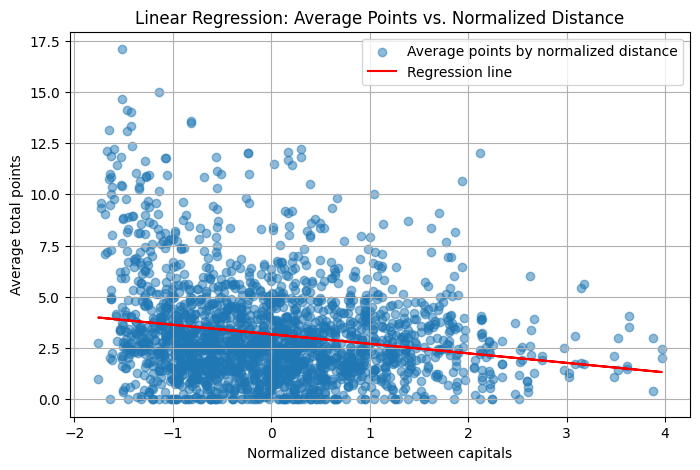

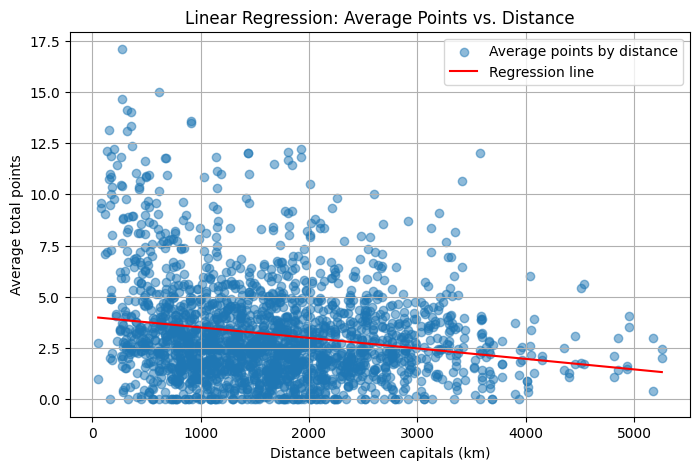

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     81.81
Date:                Sat, 25 Jan 2025   Prob (F-statistic):           3.28e-19
Time:                        14:40:31   Log-Likelihood:                -4874.3
No. Observations:                2135   AIC:                             9753.
Df Residuals:                    2133   BIC:                             9764.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.1687    

In [25]:
file_path = "../data/fulldata.csv"
data = pd.read_csv(file_path, low_memory = False)

data = data[(data["from_country"] != "au") & (data["to_country"] != "au")]

aggregated_data = data.groupby(["from_country", "to_country"], as_index = False).agg({
    "total_points": "mean",     # Average points awarded
    "distance": "mean"          # Distance
})

distance_mean = aggregated_data["distance"].mean()
distance_std = aggregated_data["distance"].std()
aggregated_data["distance_normalized"] = (aggregated_data["distance"] - distance_mean) / distance_std

X_agg = sm.add_constant(aggregated_data["distance_normalized"])
Y_agg = aggregated_data["total_points"]

agg_model = sm.OLS(Y_agg, X_agg).fit()      # Ordinary Least Squares for Linear Regression
agg_summary = agg_model.summary()

x_plot_original = np.linspace(aggregated_data["distance"].min(), aggregated_data["distance"].max(), 100)        # Unnormalized distance predictions back to original scale for plotting
x_plot_normalized = (x_plot_original - distance_mean) / distance_std
x_plot_with_const = sm.add_constant(x_plot_normalized)
y_plot = agg_model.predict(x_plot_with_const)

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data['distance_normalized'], aggregated_data['total_points'], alpha=0.5, label='Average points by normalized distance')
plt.plot(aggregated_data['distance_normalized'], agg_model.predict(X_agg), color='red', label='Regression line')
plt.title('Linear Regression: Average Points vs. Normalized Distance')
plt.xlabel('Normalized distance between capitals')
plt.ylabel('Average total points')
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/overall_normalized.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(aggregated_data["distance"], aggregated_data["total_points"], alpha=0.5, label="Average points by distance")
plt.plot(x_plot_original, y_plot, color="red", label="Regression line")
plt.title("Linear Regression: Average Points vs. Distance")
plt.xlabel("Distance between capitals (km)")
plt.ylabel("Average total points")
plt.legend()
plt.grid(True)
plt.savefig("../plots/linear_regression/overall.png")
plt.show()

print(agg_summary)


### Results explanation

· R-squared: 0.037 → only 3.7% of the variance in the average points awarded can be explained by the distance, so distance is not a strong predictor of the overall voting behavior.

· Prob (F-statistic): 3.28e-19 → The very low p-value (<0.05) indicates that the overall model is statistically significant, meaning that distance should have some effect on Eurovision voting, but very small.

· Coefficients:

- Intercept (const): 3.1687 → Represents the predicted average points a country at an average distance from another country would receive.

- Distance Coefficient (normalized): -0.4648 → For every 1-standard deviation increase in distance, the expected number of points decreases by 0.4648.

- p-value (P>|t|): 0.000 → The effect of distance is highly statistically significant (unlikely to be due to random chance).

Though statistically significant, this effect is very small in magnitude, suggesting that distance only slightly reduces the points awarded.

While distance has a small but significant negative impact on points awarded, the low R-squared suggests that other factors—such as cultural, political, and historical ties—likely play a much larger role

# A PARTIR DE AQUÍ ES LO BUENO

In [5]:
file_path = "../data/fulldata.csv"
data = pd.read_csv(file_path)
country_info_path = "../data/country_info.csv"
country_info = pd.read_csv(country_info_path)

/tmp/ipykernel_14249/238078281.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [6]:
def analyze_country_data_by_name(country_name, data, country_info):
    """
    Analyze the relationship between distance and historical average points given by a country, 
    using the country's English name as input.

    Parameters:
    - country_name (str): English name of the country giving the votes (e.g., "Spain").
    - data (DataFrame): Dataset containing voting data with columns "from_country", "to_country", "total_points", "distance", and "year".
    - country_info (DataFrame): Dataset containing country information with columns "name" (English name) and "code" (country code).

    Output:
    - Displays a scatter plot with the regression line.
    - Prints the regression summary.
    """
    # Map the country name to its corresponding country code
    country_row = country_info[country_info["name"].str.lower() == country_name.lower()]
    if country_row.empty:
        print(f"Country "{country_name}" not found in the country information dataset.")
        return
    country_code = country_row["code"].values[0]

    # Filter the data for the specified country as the voting country
    country_data = data[data["from_country"] == country_code]

    # Calculate the average points given by the country to each other country by year
    annual_means = country_data.groupby(["to_country", "year"], as_index=False).agg({
        "total_points": "mean"
    })

    # Calculate the historical average points given by the country to each other country
    historical_means = annual_means.groupby("to_country", as_index=False).agg({
        "total_points": "mean"
    })

    # Merge the historical averages with distance data
    distance_data = country_data[["to_country", "distance"]].drop_duplicates()
    historical_means = historical_means.merge(distance_data, on="to_country", how="left")

    # Drop rows with missing values
    historical_means = historical_means.dropna()

    # Define the independent (X) and dependent (Y) variables for regression
    X_hist = historical_means["distance"]
    Y_hist = historical_means["total_points"]

    # Add a constant for the regression model
    X_hist = sm.add_constant(X_hist)

    # Fit a linear regression model
    hist_model = sm.OLS(Y_hist, X_hist).fit()

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.scatter(historical_means["distance"], historical_means["total_points"], alpha=0.7, label="Historical average points")
    plt.plot(historical_means["distance"], hist_model.predict(X_hist), color="red", label="Regression line")
    plt.title(f"Regression: Historical Avg Points vs. Distance ({country_name})")
    plt.xlabel("Distance between capitals (km)")
    plt.ylabel("Historical average points given")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the regression summary
    print(hist_model.summary())

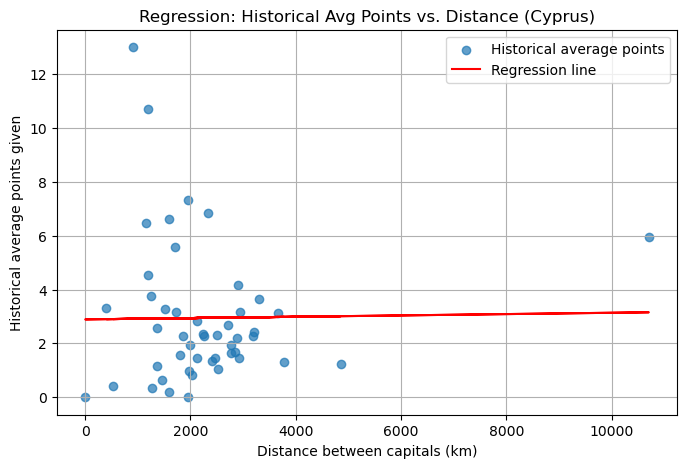

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                  0.009612
Date:                Wed, 22 Jan 2025   Prob (F-statistic):              0.922
Time:                        11:08:00   Log-Likelihood:                -114.13
No. Observations:                  48   AIC:                             232.3
Df Residuals:                      46   BIC:                             236.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8902      0.694      4.166      0.0

In [7]:
analyze_country_data_by_name("Cyprus", data, country_info)

## Without Australia:

In [8]:
def analyze_country_votes_by_name_except_Australia(country_name, data, country_info):
    """
    Analyze the relationship between distance and historical average points given by a country, 
    using the country's English name as input. Excludes any data related to Australia.

    Parameters:
    - country_name (str): English name of the country giving the votes (e.g., "Spain").
    - data (DataFrame): Dataset containing voting data with columns "from_country", "to_country", "total_points", "distance", and "year".
    - country_info (DataFrame): Dataset containing country information with columns "name" (English name) and "code" (country code).

    Output:
    - Displays a scatter plot with the regression line.
    - Prints the regression summary.
    """
    # Map the country name to its corresponding country code
    country_row = country_info[country_info["name"].str.lower() == country_name.lower()]
    if country_row.empty:
        print(f"Country "{country_name}" not found in the country information dataset.")
        return
    country_code = country_row["code"].values[0]

    # Exclude Australia-related data
    australia_code = country_info[country_info["name"].str.lower() == "australia"]["code"].values[0]
    filtered_data = data[(data["from_country"] != australia_code) & (data["to_country"] != australia_code)]

    # Filter the data for the specified country as the voting country
    country_data = filtered_data[filtered_data["from_country"] == country_code]

    # Calculate the average points given by the country to each other country by year
    annual_means = country_data.groupby(["to_country", "year"], as_index=False).agg({
        "total_points": "mean"
    })

    # Calculate the historical average points given by the country to each other country
    historical_means = annual_means.groupby("to_country", as_index=False).agg({
        "total_points": "mean"
    })

    # Merge the historical averages with distance data
    distance_data = country_data[["to_country", "distance"]].drop_duplicates()
    historical_means = historical_means.merge(distance_data, on="to_country", how="left")

    # Drop rows with missing values
    historical_means = historical_means.dropna()

    # Define the independent (X) and dependent (Y) variables for regression
    X_hist = historical_means["distance"]
    Y_hist = historical_means["total_points"]

    # Add a constant for the regression model
    X_hist = sm.add_constant(X_hist)

    # Fit a linear regression model
    hist_model = sm.OLS(Y_hist, X_hist).fit()

    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.scatter(historical_means["distance"], historical_means["total_points"], alpha=0.7, label="Historical average points")
    plt.plot(historical_means["distance"], hist_model.predict(X_hist), color="red", label="Regression line")
    plt.title(f"Regression: Historical Avg Points vs. Distance ({country_name}) (Excluding Australia)")
    plt.xlabel("Distance between capitals (km)")
    plt.ylabel("Historical average points given")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the regression summary
    print(hist_model.summary())

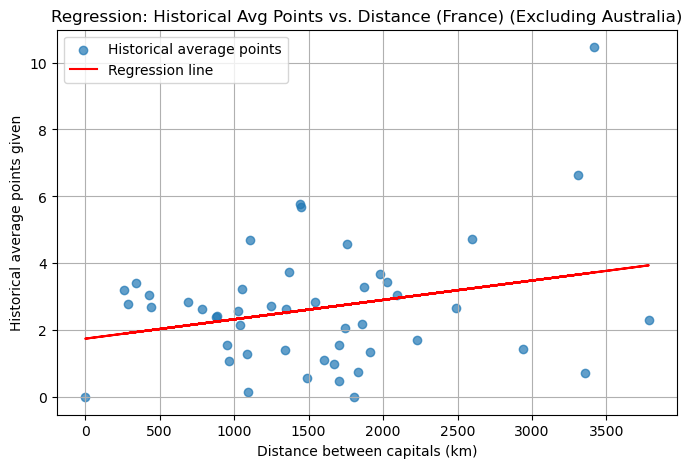

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     3.421
Date:                Wed, 22 Jan 2025   Prob (F-statistic):             0.0708
Time:                        11:08:00   Log-Likelihood:                -96.457
No. Observations:                  48   AIC:                             196.9
Df Residuals:                      46   BIC:                             200.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7492      0.553      3.166      0.0

In [9]:
analyze_country_votes_by_name_except_Australia("France", data, country_info)

### Vales Regression (Loss of Sanity)

Index(['Unnamed: 0', 'year', 'round', 'from_country', 'to_country',
       'total_points', 'tele_points', 'jury_points', 'Year_from',
       'iso-alpha-3_from', 'chrstprotpct_from', 'chrstcatpct_from',
       'chrstorthpct_from', 'judgenpct_from', 'islmgenpct_from',
       'nonreligpct_from', 'StateAbb_from', 'city_from', 'lat_from',
       'lon_from', 'GDP per capita (current US$)_from',
       'Population, total_from', 'Year_to', 'iso-alpha-3_to',
       'chrstprotpct_to', 'chrstcatpct_to', 'chrstorthpct_to', 'judgenpct_to',
       'islmgenpct_to', 'nonreligpct_to', 'StateAbb_to', 'city_to', 'lat_to',
       'lon_to', 'GDP per capita (current US$)_to', 'Population, total_to',
       'distance'],
      dtype='object')


/tmp/ipykernel_14249/3106296750.py:2: DtypeWarning: Columns (20,34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


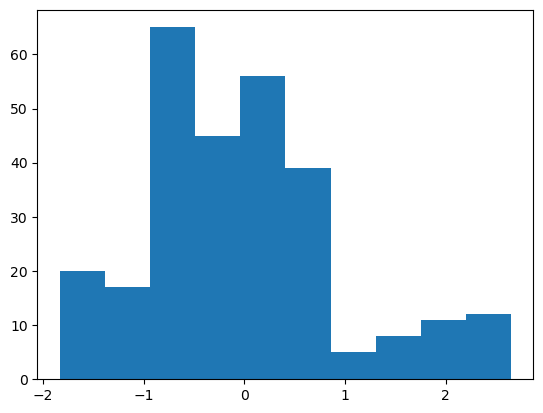

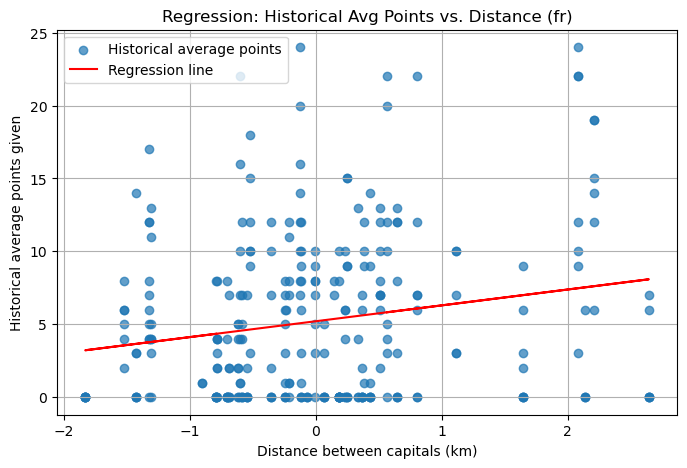

                            OLS Regression Results                            
Dep. Variable:           total_points   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     10.53
Date:                Wed, 22 Jan 2025   Prob (F-statistic):            0.00132
Time:                        11:32:23   Log-Likelihood:                -871.47
No. Observations:                 278   AIC:                             1747.
Df Residuals:                     276   BIC:                             1754.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
distance       1.0880      0.335      3.244      0.0

In [35]:
file_path = "../data/fulldata.csv"
data = pd.read_csv(file_path)
print(data.columns)
coutry_name = "fr"
data = data[data["from_country"] == coutry_name]
data = data[data["to_country"] != "au"]
#data= data[data["to_country"] != "il"]
data = data[data["year"] >= 2016]

data["distance"] = (data["distance"] - data["distance"].mean()) / data[
    "distance"
].std() 

data["constant"] = 1
plt.hist(data["distance"])
plt.show()
linear_model = sm.OLS( data["total_points"],data[["distance", "constant"]]).fit()
data["prediction"] = linear_model.predict(data[["distance", "constant"]])
# Plot the results
plt.figure(figsize=(8, 5))
plt.scatter(data["distance"],data["total_points"], alpha=0.7, label="Historical average points")
plt.plot(data["distance"],data["prediction"] , color="red", label="Regression line")
plt.title(f"Regression: Historical Avg Points vs. Distance ({coutry_name})") 
plt.xlabel("Distance between capitals (km)")
plt.ylabel("Historical average points given")
plt.legend()
plt.grid(True)
plt.show()

    # Print the regression summary
print(linear_model.summary())